In [2]:
import pygame
import PyParticles
import matplotlib.pyplot as plt
import pandas as pd
import micplot

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
def create_environment(size, environment_dict):
    when_measure_starts = environment_dict['when_measure_starts']
    measure_speed_decrease = environment_dict['measure_speed_decrease']
    env = PyParticles.Environment(size, when_measure_starts=when_measure_starts, measure_speed_decrease=measure_speed_decrease,
                                  mass_of_air=0, elasticity=1)
    return env

def run_simulation(disease):
    size = calculate_area(disease['environment'], disease['population'])
    screen = pygame.display.set_mode(size)
    env = create_environment(size, disease['environment'])
    
    for props in disease['population']:
        env.addParticles(**props)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        env.update()
        
        screen.fill(env.colour)
        for p in env.particles:
            pygame.draw.circle(screen, p.colour, (int(p.x), int(p.y)), p.size, p.thickness)

        pygame.display.flip()
        if env.particle_status[-1]['Infected'] == 0 and env.particle_status[-1]['Incubation'] == 0:
            running = False
        pygame.time.delay(200)
    pygame.quit()
    return env

def plot_disease_spread(env, ax=None):
    ax = ax or plt.subplots()
    nr_infected = [c['Infected'] for c in env.particle_status]
    nr_healthy = [c['Healthy'] for c in env.particle_status]
    nr_recovered = [c['Recovered'] for c in env.particle_status]
    ax.plot(nr_healthy, color='b', label='Healthy')
    ax.plot(nr_infected, color='r', label='Infected')
    ax.plot(nr_recovered, color='g', label='Recovered')
    plt.legend()
    return plt.gca()

In [4]:
def generate_population(properties=None):
    if properties is None:
        properties = dict()
    speed = properties.get('speed', 1)
    size = properties.get('size', 4)
    nr_infected = properties.get('nr_infected', 2)
    pct_quarantined = properties.get('pct_quarantined', 0)
    population_size = properties.get('population_size', 200)
    
    duration = properties.get('duration', 500)
    incubation_time = properties.get('incubation_time', 0)

    infected_population = dict(n=nr_infected, speed=speed, size=size, days_infected=1, duration=duration, incubation_time=incubation_time)
    quarantined_not_infected_population = dict(n=round(pct_quarantined * (population_size - nr_infected)), speed=0, size=size,
                                              duration=duration, incubation_time=incubation_time)
    moving_not_infected_population = dict(n=round((1 - pct_quarantined) * (population_size - nr_infected)), speed=speed, size=size,
                                         duration=duration, incubation_time=incubation_time)

    all_populations = [infected_population, quarantined_not_infected_population, moving_not_infected_population]
    return all_populations

def generate_environment(properties=None):
    if properties is None:
        properties = dict()
    height_pixels_per_person = properties.get('height_pixels_per_person', 3)
    when_measure_starts = properties.get('when_measure_starts', 1)
    measure_speed_decrease = properties.get('measure_speed_decrease', 0.5)
    return {'height_pixels_per_person': height_pixels_per_person, 'when_measure_starts': when_measure_starts,
           'measure_speed_decrease': measure_speed_decrease}

def generate_disease(properties=None):
    if properties is None:
        properties = dict()
    return {'environment': generate_environment(properties), 'population': generate_population(properties)}

def vary_one_parameter(parameter_name, parameter_values, basic_dict=None):
    if basic_dict is None:
        basic_dict = dict()
    new_dicts = []
    for v in parameter_values:
        basic_dict[parameter_name] = v
        new_dicts.append(basic_dict.copy())
    return [generate_disease(dct) for dct in new_dicts]

def calculate_area(dct, population_dicts):
    height_pixels_per_person = dct.get('height_pixels_per_person', 3)
    population = sum(population_dict['n'] for population_dict in population_dicts)
    height = population * height_pixels_per_person
    width = 1.5 * height
    return (round(width), round(height))

def calculate_maximum_simultaneous_infections(env, as_fraction=True):
    maximum_simultaneous_infects_absolute = max(env.particle_status, key=lambda x: x['Infected'])['Infected']
    if as_fraction:
        nr_people = sum(env.particle_status[0].values())
        return maximum_simultaneous_infects_absolute / nr_people
    return maximum_simultaneous_infects_absolute
                                             
def calculate_total_infected(env, as_fraction=True):
    nr_people = sum(env.particle_status[0].values())
    nr_people_infected_begin = env.particle_status[0]['Infected']
    total_infections_absolute = env.particle_status[-1]['Recovered'] + env.particle_status[-1]['Infected'] - nr_people_infected_begin
    if as_fraction:
        healthy_people_begin = nr_people - nr_people_infected_begin
        return total_infections_absolute / healthy_people_begin
    return total_infections_absolute
    
def plot_parameter_results(parameter_name, parameter_values, envs):
    total_simultaneous_infected = [calculate_maximum_simultaneous_infections(env) for env in envs]
    
    total_infected = [calculate_total_infected(env) for env in envs]
    results = pd.DataFrame({'Total infected': total_infected,
                           'Maximum simultaneously infected': total_simultaneous_infected},
                           index=pd.Index(parameter_values, name=parameter_name)).sort_index(ascending=False)
    ax = results.pipe(micplot.micompanyify, plottype='bar', strfmt='.1%', ascending=None)
    ax.set_xlabel('Percentage of the population')

def run_simulations_with_multiple_parameters(parameter_name, parameter_values, basic_dict=None):
    dicts = vary_one_parameter(parameter_name, parameter_values, basic_dict)
    fig, axes = plt.subplots(len(dicts), 1, sharex=True, sharey=True)
    envs = []
    for ax, disease in zip(axes, dicts):
        
        env = run_simulation(disease)
        envs.append(env)
        plot_disease_spread(env, ax)
        
    plot_parameter_results(parameter_name, parameter_values, envs)
    return envs

No handles with labels found to put in legend.


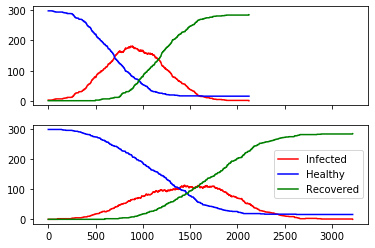

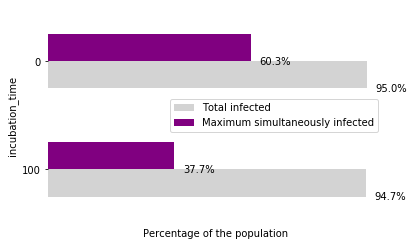

In [41]:
envs = run_simulations_with_multiple_parameters('incubation_time', [0, 100], {'population_size': 300, 'when_measure_starts': 1, 'speed': 1.5})

No handles with labels found to put in legend.


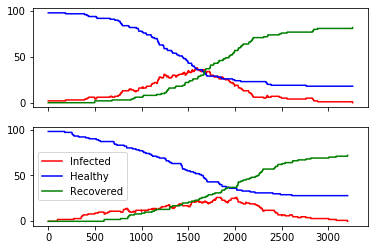

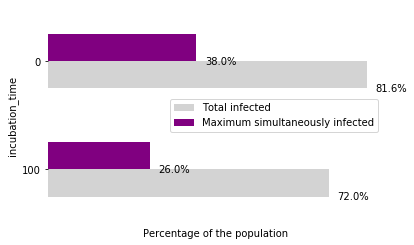

In [57]:
envs = run_simulations_with_multiple_parameters('incubation_time', [0, 100], {'population_size': 100, 'when_measure_starts': 0.05, 'speed': 1.5, 'size': 1})

No handles with labels found to put in legend.


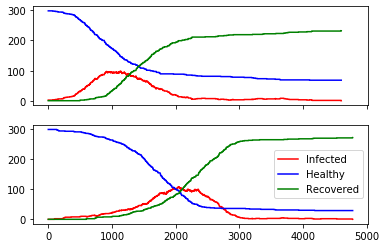

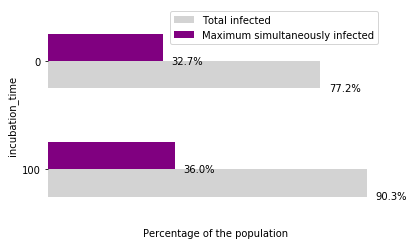

In [50]:
import importlib; importlib.reload(PyParticles);
envs = run_simulations_with_multiple_parameters('incubation_time', [0, 100], {'population_size': 300, 'when_measure_starts': 0.02, 'speed': 2,
                                                                              'measure_speed_decrease': 0.1})

No handles with labels found to put in legend.
No handles with labels found to put in legend.


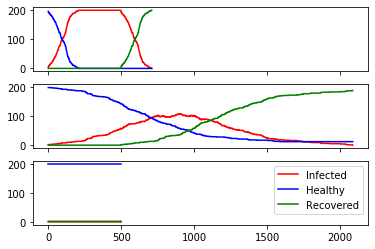

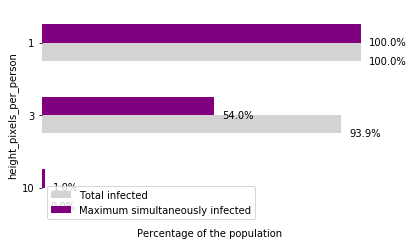

In [5]:
envs = run_simulations_with_multiple_parameters('height_pixels_per_person', [1, 3, 10])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


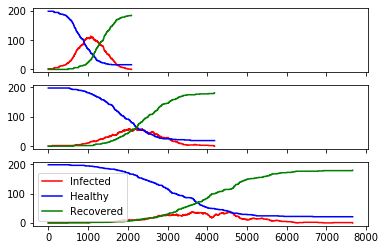

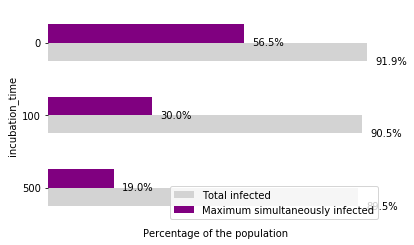

In [24]:
envs = run_simulations_with_multiple_parameters('incubation_time', [0, 100, 500], {'incubation_time': 50})

No handles with labels found to put in legend.
No handles with labels found to put in legend.


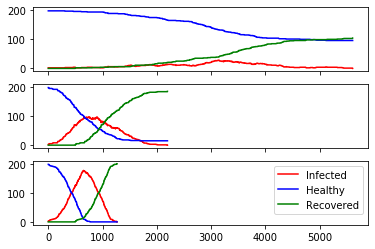

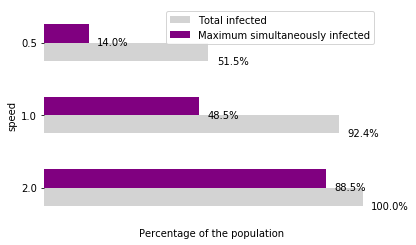

In [6]:
envs = run_simulations_with_multiple_parameters('height_', [0.5, 1, 2])

No handles with labels found to put in legend.


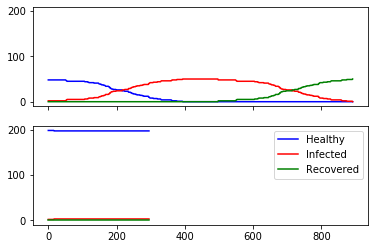

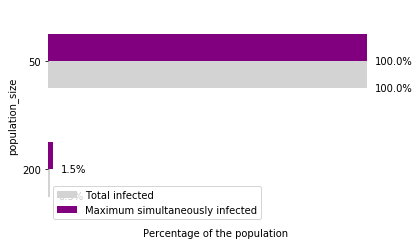

In [10]:
envs = run_simulations_with_multiple_parameters('population_size', [50, 200], {'speed': 1.5, 'size': 2})

No handles with labels found to put in legend.


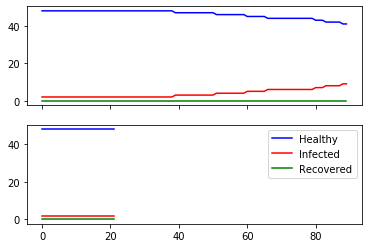

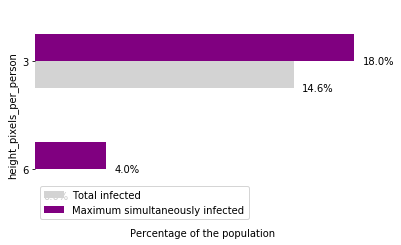

In [15]:
envs = run_simulations_with_multiple_parameters('height_pixels_per_person', [3, 6], {'population_size': 50, 'size': 2, 'speed': 2})

No handles with labels found to put in legend.


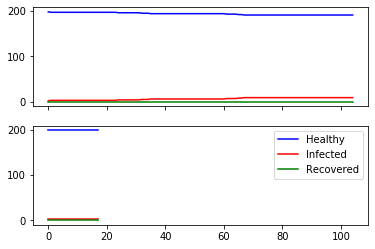

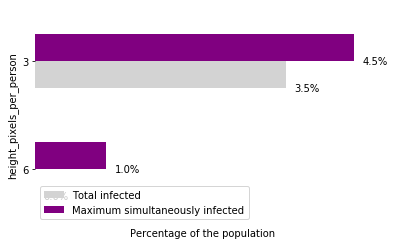

In [16]:
envs = run_simulations_with_multiple_parameters('height_pixels_per_person', [3, 6], {'population_size': 200, 'size': 2, 'speed': 2})